In [10]:
import aggregation
import pandas as pd

# df = pd.read_csv(f'/Users/jkember/Documents/nia_health/NHANES/A_preprocess_data/cleaned_data/NHANES_benchmarking_male.csv')
# df[['apob','ldlc','hdlc','cystatin_c','age']].to_csv('test.csv', index=False)


In [3]:

delta_age_df = aggregation.get_delta_age_dataframe(
    '/Users/jkember/Documents/nia_health/NHANES/A_preprocess_data/cleaned_data/NHANES_benchmarking_male.csv',
    'delta_age_paths.json'
)
weights = aggregation.get_feature_weights(delta_age_df)

<Axes: >

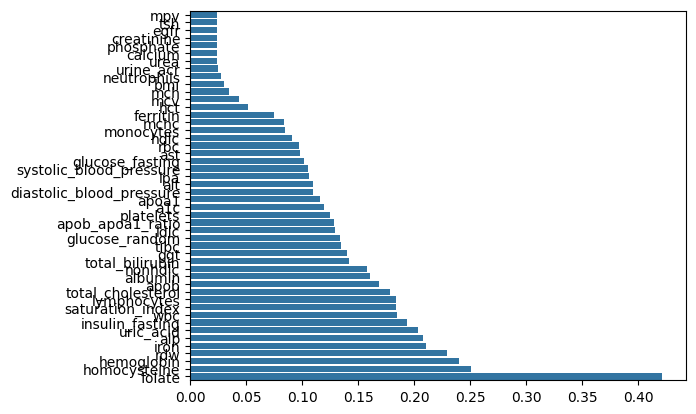

In [9]:
import seaborn as sns

sns.barplot(pd.Series(weights).sort_values(), orient='h')

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.optimize import lsq_linear
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from scipy.interpolate import RegularGridInterpolator


def _get_delta_age_estimator(delta_age_array):

    # Load delta-age array.
    delta_age = pd.read_csv(delta_age_array, index_col=0)
    deltas       = delta_age.to_numpy()
    feature_vals = delta_age.index.values
    age_vals     = delta_age.columns.values.astype(float)

    # Fit interpolator.
    delta_age_intepolator = RegularGridInterpolator(points=[feature_vals, age_vals], values=deltas)

    # Define function for perfomring interpolation.
    def delta_age_estimator(feature_val, age_val):

        # Clip age and feature at min.max of defined range.
        feature_val = np.clip(feature_val, np.min(feature_vals), np.max(feature_vals))
        age_val = np.clip(age_val, np.min(age_vals), np.max(age_vals))

        # Interpolate delta-age at age-feature pair.
        delta_age = delta_age_intepolator((feature_val, age_val))

        return delta_age

    return delta_age_estimator



def get_delta_age_dataframe(feature_data_csv, delta_age_paths_json, output_dir):

    # Load dictionary mapping features (keys) to the path of their delta-age array (values).
    with open(delta_age_paths_json, 'r') as f:
        delta_age_paths = json.load(f)

    # Load dataframe including all features and age.
    features = list(delta_age_paths.keys())
    df = pd.read_csv(feature_data_csv)

    if 'age' not in df.columns:
        raise KeyError('Ageis missing from the CSV.')

    missing = [col for col in features if col not in delta_age_paths]
    if missing:
        raise KeyError(
            f"The following feature columns from '{feature_data_csv}' "
            f"are missing in the JSON keys:\n{missing}"
        )

    # Impute missing data.
    imputer = KNNImputer()
    df_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)
    df_imputed['age'] = df['age']
    df_imputed.to_csv(f'{output_dir}/data_imputed.csv', index=False)

    # Calculate delta-age for each feature.
    df_delta_ages = pd.DataFrame()
    for feature in features:

        delta_age_estimator = _get_delta_age_estimator(delta_age_paths[feature])
        df_delta_ages[feature] = delta_age_estimator(df_imputed[feature], df_imputed['age'])

    df_delta_ages.to_csv(f'{output_dir}/biomarker_delta_ages.csv', index=False)

    return df_delta_ages



def get_feature_weights(df, output_dir, min_weight=.025, min_error=0.9):
    """
    Compute non-negative feature weights that approximate the direction of maximal correlation.
    """

    df_norm = zscore(df)
    pc1_scores = PCA(n_components=1).fit_transform(df_norm).ravel()

    non_neg_model = lsq_linear(df_norm, pc1_scores, bounds=(min_weight, np.inf))
    non_neg_betas = non_neg_model.x

    approx = df_norm @ non_neg_betas
    error = r2_score(pc1_scores, approx)

    if error < min_error:
        print(f'Warning: non-negative approximation performed poorly: R2={error:.3f}')

    # Normalize weights to unit length.
    non_neg_betas /= np.linalg.norm(non_neg_betas)
    weights = dict(zip(df.columns, non_neg_betas))

    # Save to .csv and .png
    pd.Series(weights, name='weight').to_csv(f'{output_dir}/model_weights.csv')
    _plot_weights(weights, output_dir)

    return weights


def _plot_weights(weights, output_dir):

    weights = pd.Series(weights).sort_values()

    fig, ax = plt.subplots(figsize=(7, 8))
    sns.barplot(weights, orient='h', color='royalblue')
    ax.set_xlabel('Weight')
    ax.grid(linestyle='--', alpha=.25, axis='x', color='k')
    sns.despine()

    # Save
    fig.savefig(f'{output_dir}/model_weights.png', dpi=1000, bbox_inches='tight')
    plt.close(fig)


In [ ]:
df = pd.read_csv('/Users/jkember/Documents/nia_health/NHANES/biological_age/data/output_male/biomarker_delta_ages.csv')
min_weight = .025
min_error = .9


df_norm = zscore(df)

pca = PCA(n_components=1).fit(df_norm)
pc_weights = pca.components_.flatten()
pc_scores = pca.transform(df_norm).flatten()

pc_weights[pc_weights < 0] = .01
nn_weights = pc_weights

error = r2_score(pc_scores, df_norm @ nn_weights)

# Normalize weights to unit length.
nn_weights /= np.linalg.norm(nn_weights)
weights = dict(zip(df.columns, nn_weights))



0.9881232664277769